### Imports

In [1]:
%cd ..

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [2]:
!pwd

/home/ds/DataScience/home/ademyanchuk/Projects/ulmfit-multilingual


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.text import *

In [5]:
from ulmfit.pretrain_lm import *

In [6]:
cuda_id = 1
torch.cuda.set_device(cuda_id)

### Preparing data

In [7]:
# batch size
bs = 20

In [8]:
# use data from smaller sample of wiki
# data is recieved through prepare_wiki.sh script
wiki_data_path = Path('data/wiki/ru-2/')

In [9]:
wiki_data_path.ls()

[PosixPath('data/wiki/ru-2/ru.wiki.test.tokens'),
 PosixPath('data/wiki/ru-2/ru.wiki.valid.tokens'),
 PosixPath('data/wiki/ru-2/ru.wiki.train.tokens'),
 PosixPath('data/wiki/ru-2/models'),
 PosixPath('data/wiki/ru-2/tmp_lm')]

In [9]:
# provide train and valid path
trn_path = wiki_data_path/'ru.wiki.train.tokens'
val_path = wiki_data_path/'ru.wiki.valid.tokens'

In [11]:
# create a databunch object from data_frames
# data_frames are provided through `read_wiki_articles` function
# from `ulmfit.pretrain_lm`
data_lm = TextLMDataBunch.from_df(path=wiki_data_path, train_df=read_wiki_articles(trn_path),
                                  valid_df=read_wiki_articles(val_path), 
                                  classes=None, bs=bs, text_cols='texts')

In [15]:
itos, stoi, trn_path = data_lm.vocab.itos, data_lm.vocab.stoi, data_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', data_lm.vocab.itos[:20])

Size of vocabulary: 59184
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', '.', 'в', 'и', '\n\n', 'на', '«', '»', '\n', ')', '(', '—']


In [32]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(3857, 447)

In [22]:
data_lm.train_ds[0][0]

Text xxbos = xxmaj розовая чайка = 
 xxmaj розовая чайка 

 xxmaj розовая чайка ( ) — вид птиц из семейства xxunk ( xxmaj xxunk ) , единственный в роде розовых чаек ( & ' xxmaj xxunk & ' ) . 

 xxmaj описание . 
 xxmaj длина тела около 35 см . xxmaj спина и верх крыльев серо - xxunk , голова , грудь и xxunk розовые , на шее узкий чёрный xxunk . xxmaj клюв чёрный , ноги красные . xxmaj хвост xxunk формы . 

 xxmaj полёт розовой чайки лёгкий , напоминающий полёт xxunk . xxmaj по отношению к человеку птица обычно мало xxunk и xxunk . xxmaj на море она главным образом держится на плавающих xxunk , а вот в тундре , на озёрах , чайка часто садится на воду и даже купается . 

 xxmaj вокализация . 
 xxmaj голос этого вида гораздо выше и xxunk , чем у других чаек , и отличается большим разнообразием . xxmaj чаще всего xxunk крик вроде « э - у , э - у » ; xxunk , они издают короткий крик « вя , вя , вя » , если очень xxunk — « xxunk - xxunk » , а при нападении другой чайки того же вида или xxunk

In [24]:
data_lm.train_ds[0][0].data[:10]

array([    2,    28,     4, 19014, 19015,    28,    16,     4, 19014, 19015])

In [11]:
data_lm.show_batch()

idx,text
0,"xxbos \n = xxmaj шишмарёв , xxmaj глеб xxmaj семёнович = \n xxmaj шишмарёв , xxmaj глеб xxmaj семёнович \n\n xxmaj глеб xxmaj семёнович xxmaj шишмарёв ( 1781 — 1835 ) — контр - адмирал , командир гвардейского экипажа , путешественник . \n\n xxmaj родился в 1781 году . xxmaj происходил из дворян xxmaj ржевского уезда , воспитывался в xxmaj морском кадетском корпусе , откуда выпущен гардемарином в 1801 году"
1,"xxunk землями между двумя государствами . к первым годам самостоятельного правления короля xxmaj альфонсо v относятся и безуспешные попытки графа xxmaj кастилии организовать несколько мятежей своих сторонников в xxmaj леоне . \n\n xxmaj окончательный разрыв отношений между графством xxmaj кастилия и королевством xxmaj леон произошёл в xxunk году , когда в xxmaj кастилии начались преследования сторонников союза с xxmaj леоном . xxmaj многие xxunk дворяне бежали ко двору короля xxmaj"
2,"войска xxmaj иоанна v xxmaj xxunk , xxmaj иван xxmaj александр сам стремился овладеть городом . в конце 1342 года xxmaj кантакузину пришлось опять просить помощи xxmaj умура , на этот раз против болгар . в начале 1343 года xxmaj умур прибыл со своим флотом в устье xxmaj дуная . xxmaj он высадился в устье xxmaj марицы , поднялся по её течению и xxunk болгар от xxmaj xxunk . xxmaj"
3,"верстах от xxmaj xxunk , 40 верстах от xxmaj xxunk . \n\n xxmaj культура . \n 12 июля 2009 прошла встреча бывших жителей деревни . \n xxbos \n = xxmaj уилкинсон , xxmaj том = \n xxmaj уилкинсон , xxmaj том \n\n xxmaj то ́ мас xxmaj дже ́ xxunk ( xxmaj том ) xxmaj уи ́ xxunk , известный как xxmaj том xxmaj уилкинсон ( ; род . 5"
4,"граф xxmaj суньер xxup ii и епископ xxmaj xxunk в 889 год прибыли ко двору короля xxmaj эда в xxmaj орлеане и получили от него xxunk хартию , согласно которой епископство xxmaj жирона получало значительные владения в графстве xxmaj осона , а покровителями епархии xxmaj жироны объявлялись графы xxmaj ампурьяса . xxmaj это было единственное появление одного из графов xxmaj испанской марки при дворе короля xxmaj эда за всё время"


In [33]:
# save databunch
data_lm.save('tmp_lm')

In [10]:
# load databunch
data_lm = TextLMDataBunch.load(wiki_data_path, 'tmp_lm', bs=bs)

#### Create Learner and train Language Model

In [18]:
# create learner for training on wiki from scratch
learner = language_model_learner(data=data_lm, drop_mult=1.0)

In [19]:
# change Adam default params
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [20]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f0e929c6f28>>]

In [21]:
# add save callback
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [22]:
learner.callback_fns

[fastai.basic_train.Recorder,
 functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, every='epoch', name='lm')]

In [23]:
# unfreeze all layers
learner.unfreeze()

In [24]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


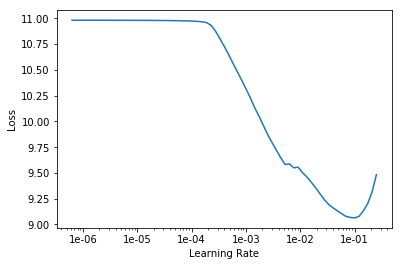

In [25]:
learner.recorder.plot(skip_end=15)

In [26]:
# define non-default momentums
moms=(0.8,0.7)

In [27]:
learner.fit_one_cycle(10, 5e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,5.712268,5.179298,0.296366
2,5.087754,4.683986,0.314654
3,4.970438,4.417627,0.329775
4,4.819845,4.289938,0.344446
5,4.646383,4.191298,0.353953
6,4.492280,4.109755,0.360973
7,4.467671,4.042253,0.369003
8,4.213881,3.995798,0.374132
9,4.056872,3.986120,0.375951
10,3.935030,3.984321,0.376229


In [28]:
# save model
learner.save('ru-2-best')

### Fine tune on ruSentEval

In [8]:
# path for ruSentEval data
rusent_data_path = Path('data/ruSentEval/')

In [9]:
rusent_data_path.ls()

[PosixPath('data/ruSentEval/texts.csv'),
 PosixPath('data/ruSentEval/models'),
 PosixPath('data/ruSentEval/tmp_clas'),
 PosixPath('data/ruSentEval/texts-sample.csv'),
 PosixPath('data/ruSentEval/tmp_lm'),
 PosixPath('data/ruSentEval/tmp_clas_sample'),
 PosixPath('data/ruSentEval/negative.csv'),
 PosixPath('data/ruSentEval/positive.csv')]

In [10]:
# create LM DataBunch from csv (sample) which is done by `merge-and-sample-rusent.ipynb`
data1_lm = TextLMDataBunch.from_csv(rusent_data_path, 'texts-sample.csv', bs=bs)

In [11]:
itos, stoi, data_path = data1_lm.vocab.itos, data1_lm.vocab.stoi, data1_lm.path
print('Size of vocabulary:', len(itos))
print('First 20 words in vocab:', itos[:20])
print(str(data_path))

Size of vocabulary: 7797
First 20 words in vocab: ['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', ')', '(', ':', '/', 'не', '.', 'я', 'и', 'в', '!', '\n']
data/ruSentEval


In [12]:
(data1_lm.path/'models').ls()

[PosixPath('data/ruSentEval/models/first-sample-cls.pth'),
 PosixPath('data/ruSentEval/models/third.pth'),
 PosixPath('data/ruSentEval/models/third-sample-cls.pth'),
 PosixPath('data/ruSentEval/models/first.pth'),
 PosixPath('data/ruSentEval/models/fit_head.pth'),
 PosixPath('data/ruSentEval/models/second-sample-cls.pth'),
 PosixPath('data/ruSentEval/models/itos.pkl'),
 PosixPath('data/ruSentEval/models/tmp.pth'),
 PosixPath('data/ruSentEval/models/fine_tuned_enc.pth'),
 PosixPath('data/ruSentEval/models/ru-2-best.pth'),
 PosixPath('data/ruSentEval/models/fine_tuned.pth'),
 PosixPath('data/ruSentEval/models/second.pth')]

In [13]:
len(data1_lm.train_ds), len(data1_lm.valid_ds)

(18146, 4537)

In [14]:
# save data bunch 
data1_lm.save('tmp_lm_sample')

In [10]:
data1_lm = TextLMDataBunch.load(rusent_data_path, 'tmp_lm_sample', bs=bs)

In [15]:
data1_lm.show_batch()

idx,text
0,"xxbos xxunk а я вот давно по этой причине не плакала ( ( ( xxmaj всё какие - то другие причины xxunk ... xxbos xxunk xxunk , ладно . а где ты xxunk ? у меня только xxunk часов будет ) xxbos и осталось пережить самую xxunk неделю в xxunk со всеми xxunk ( ( ( http : / / t.co / xxunk xxbos xxunk все обычно ) мала я"
1,"! * ; ( ( xxbos сестра xxunk , сказала маме что хочет xxunk xxunk xxrep 4 ) xxbos xxmaj наши мальчики - зайчики скоро уедут на xxunk xxrep 4 . ( ( 8 баб в одном "" классе "" это ж ужас xxrep 4 . ( ( ( xxbos как всегда на один xxmaj xxunk надежда в европе ) ну еще верим в xxmaj зенит хотя с такой xxunk"
2,"xxunk xxbos - xxmaj лёша . - что ? блин , ты меня xxunk . - xxup :d http : / / t.co / xxunk xxbos xxup rt xxunk : xxmaj завтра xxmaj день xxmaj конституции ! "" xxmaj единая xxmaj россия "" xxunk уроки xxunk xxmaj конституции xxup рф для xxunk ! xxmaj по - моему хорошая xxunk ) xxbos # followback а так хочется реветь ( ( приеду"
3,":) xxunk xxunk :) ппц "" русский xxunk , хз кем пишется "" ппц ппц ппц ! xxbos xxup rt @askket : xxunk xxmaj xxunk : * * \n и xxunk мне xxup бобра ) ) ) xxbos в xxmaj xxunk - xxmaj альфа xxunk и черный xxunk о_о xxbos xxup rt xxunk : xxmaj пиво со сметаной - новое средство набрать килограммы ) ) xxbos xxunk у меня была"
4,"там андрей и паша ) ) xxbos xxunk xxunk ну например меня называют xxmaj xxunk , xxmaj xxunk , xxmaj xxunk и тд ) ) ) xxbos xxup rt xxunk : а еще меня бесит , когда его фамилию пишут с xxunk я на конце :| xxmaj он xxunk , друзья . # xxunk # голос xxbos xxunk а я вот xxunk ) а ты я так понимаю будешь ждать"


#### Create Learner and Finetune model from pretrained fnames

In [16]:
# pretrained model and vocab from first step of training LM
pretrained_fnames = ['ru-2-best', 'itos']

In [17]:
# create learner and provide pretrained files to finetune wiki-LM with ruSentEval data
learner = language_model_learner(data1_lm, pretrained_fnames=pretrained_fnames, drop_mult=0.3)

Unknown tokens 3275, first 100: ['rt', 't.co', '"', ':(', ':)', ':d', 'блин', ';)', ':-)', 'нг', ':((', ':-(', 'ахах', 'сижу', '=(', 'пойду', 'скучаю', 'болит', 'бля', 'ахаха', '=)', ':*', 'эх', ':3', 'о_о', 'смотрю', 'ахахах', 'пиздец', 'ладно', 'ненавижу', 'обидно', 'щас', 'сука', 'прям', 'твиттер', '\xa0', 'блять', ':))', 'нету', 'жду', ':|', '\xa0 ', 'капец', 'твит', 'боюсь', 'лень', ':(((', 'весело', 'гулять', '^_^', 'бл', 'євромайдан', 'забыла', 'аж', 'прости', 'посмотрела', 'вставать', 'тви', 'проснулась', 'больно', 'грустно', 'чувак', 'соскучилась', 'делаю', 'твои', 'пишу', 'заболела', ':-d', 'ааа', ':)))', 'сказали', 'o_o', 'ваще', 'иди', 'ddd', 'купила', 'ох', 'устала', 'каникулы', 'нахуй', 'болеть', 'даа', 'фотки', 'безумно', 'нечего', '️', 'иду', '^^', 'ахахаха', 'спокойной', 'смотрела', 'обожаю', 'твиттере', 'молодец', 'офигенный', 'поздравляю', 'лол', '♥', 'дааа', 'бесит']


In [18]:
learner.callback_fns += [partial(SaveModelCallback, every='epoch', name='lm')]

In [19]:
learner.opt_func = partial(optim.Adam, betas=(0.8, 0.99))

In [20]:
learner.metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f2ccf7c3f28>>]

In [21]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


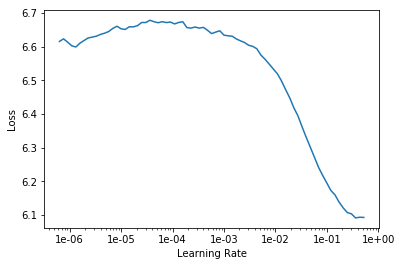

In [22]:
learner.recorder.plot(skip_end=15)

In [23]:
moms = (0.8, 0.7)

In [24]:
# learning the same way as in fastai v1 examples
learner.fit_one_cycle(1, 3e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.373447,4.082240,0.304349


In [25]:
learner.save('fit_head_sample')

In [34]:
learner.load('fit_head_sample')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (181467 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentEval
x: LMTextList (181467 items)
[Text xxbos xxup rt xxunk : 2 часа на санках - xxunk ) прям как в детстве !, Text xxbos xxmaj нашла друга из xxmaj франции , который знает английский и немного xxunk русским ) ) xxmaj он ооочень классный ) ), Text xxbos xxmaj умер xxmaj джонни xxmaj депп . xxmaj проснулась в холодном поту . xxmaj присниться же такое ( ( 
 xxmaj грусть . xxmaj печаль ., Text xxbos каждый раз я боюсь экзаменов 
 и каждый раз нормально их сдаю 

 но сегодня 
 xxup сегодня xxup мне xxup пизда 
 я не знаю нифига (, Text xxbos xxup rt @lisominizul : xxmaj едем , едем е , на военную кафедру :)]...
Path: data/ruSentEval;

Valid: LabelList
y: LMLabel (45367 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/ruSentEval
x: LMTextList (45367 items)
[Text xxbos xxunk выкинуть то придется xxu

In [26]:
learner.unfreeze()

In [27]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


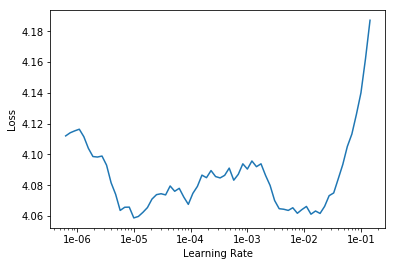

In [28]:
learner.recorder.plot(skip_end=15)

In [29]:
learner.fit_one_cycle(10, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,4.050154,4.029791,0.308869
2,3.970905,3.950660,0.316556
3,3.867994,3.895064,0.323656
4,3.736855,3.872441,0.326589
5,3.606239,3.863724,0.327692
6,3.471198,3.874571,0.327271
7,3.363645,3.888185,0.326519
8,3.261220,3.904865,0.325957
9,3.203301,3.912884,0.324692
10,3.183055,3.917482,0.324640


In [30]:
# save fine_tuned model
learner.save('fine_tuned_sample')

In [31]:
# check text generation with LM
TEXT = "сегодня утром я"
N_WORDS = 10
N_SENTENCES = 2

In [32]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

сегодня утром я называется офигеть менять постель убирать проверяет поехать сцены выглядит пам
сегодня утром я всë полина тупее невозможно спросил @rykov проезд просто болят федор


In [33]:
# save finetuned models encoder to use for classification task
learner.save_encoder('fine_tuned__sample_enc')

### Classifier

In [34]:
rusent_data_path.ls()

[PosixPath('data/ruSentEval/texts.csv'),
 PosixPath('data/ruSentEval/models'),
 PosixPath('data/ruSentEval/tmp_clas'),
 PosixPath('data/ruSentEval/texts-sample.csv'),
 PosixPath('data/ruSentEval/tmp_lm'),
 PosixPath('data/ruSentEval/tmp_clas_sample'),
 PosixPath('data/ruSentEval/negative.csv'),
 PosixPath('data/ruSentEval/tmp_lm_sample'),
 PosixPath('data/ruSentEval/positive.csv')]

In [41]:
# create classification databunch, please note usage of LM vocab
data_clas = (TextList.from_csv(path=rusent_data_path, csv_name='texts-sample.csv',
                               cols='text', vocab=data1_lm.vocab)
             .split_from_df()
             .label_from_df(cols='label')
             .databunch(bs=96))

In [42]:
# save for future use
data_clas.save('tmp_ft_clas_sample')

In [35]:
data_clas = TextClasDataBunch.load(rusent_data_path, 'tmp_ft_clas_sample', bs=96)

In [43]:
len(data_clas.vocab.itos)

7797

In [44]:
data_clas.show_batch()

text,target
"xxbos и xxup почему именно xxup так xxrep 5 ? xxrep 5 . / / и xxrep 4 . xxup это xxup же ужас xxup просто xxrep 4 . xxrep 5 ( какой - то xxrep 4 . xxup вообще xxrep 4 . / / xxrep 5 ( и xxup что xxup это xxup за xxup хрень , с xxup головой у xxup меня ! ! ? ?",negative
"xxbos мама узнала , xxup какой у меня xxunk xxunk . xxmaj xxunk на меня , пздц . xxup вот , xxup это xxup всё , xxup потому xxup что xxup мясо xxup не xxup ешь . xxup ничо xxup не xxup ешь . и всё в этом xxunk ; (",negative
xxbos xxup rt xxup xxunk _ : xxup ну xxup xxunk xxup никто xxup xxunk xxup xxunk ? в xxup xxunk xxup раз xxup вас xxup была xxup чуть xxup ле xxup ни xxup xxunk . \n xxup xxunk xxup xxunk xxup xxunk : ( xxup все # xxup rt,negative
xxbos xxup rt xxunk : xxup вот xxup что я xxup прочитал xxup xxunk xxup от xxup этого xxup меня и xxup вынесло и xxup стало xxup обидно xxup до xxup слез xxup не xxup дай xxup бог xxup джаред xxup это xxup xxunk xxup ужас ( htt …,negative
xxbos xxup привет xxup xxunk \n я xxup пришла xxup домой \n xxup сегодня xxup настроение \n xxup не xxup такое xxup как xxup вчера \n xxup но xxup все xxup равно \n xxup отличное .. \n а у xxup вас xxup как xxup дела ? ) \n ^_^,positive


In [45]:
len(data_clas.train_ds), len(data_clas.valid_ds)

(20457, 2226)

In [46]:
# create learner and train
# train classifier as in fastai imdb example
learner = text_classifier_learner(data=data_clas, drop_mult=0.5)

In [47]:
# load fine tuned encoder
learner.load_encoder('fine_tuned__sample_enc')

In [48]:
learner.freeze()

In [49]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


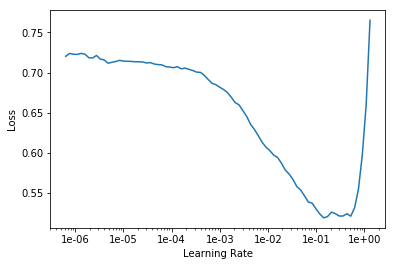

In [50]:
learner.recorder.plot()

In [51]:
moms=(0.8,0.7)

In [52]:
learner.fit_one_cycle(1, 1e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.298604,0.225152,0.893980


In [53]:
learner.save('first-ft-class-sample')

In [38]:
learner.load('first-ft-class-sample')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (204089 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...
Path: .
x: TextList (204089 items)
[Text xxbos xxunk хоть я и школота , но поверь , у нас то же самое xxup :d общество xxunk предмет типа ), Text xxbos xxmaj да , все - таки он немного похож на него . xxmaj но мой мальчик все равно лучше : d, Text xxbos xxup rt xxunk : xxmaj ну ты идиотка ) я испугалась за тебя ! ! !, Text xxbos xxup rt xxunk : " xxmaj кто то в углу сидит и погибает от голода , а мы ещё 2 порции взяли , хотя уже и так жрать не хотим " : xxup dd http : / / t.co / xxunk …, Text xxbos xxunk xxmaj вот что значит xxunk xxup :d 
 xxmaj но блин , посмотрев все части , у тебя xxunk ощущение , что авторы курили что - то xxup :d]...
Path: data/ruSentEval;

Valid: LabelList
y: CategoryList (22745 items)
[Category positive, Category positive, Category positive, Category positive, Category positive]...

In [54]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.184554,0.098150,0.955975


In [55]:
learner.save('second-ft-class-sample')

In [ ]:
learner.load('second-ft-class-sample')

In [56]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.105624,0.052071,0.973046


In [57]:
learner.save('third-ft-class-sample')

In [ ]:
learner.load('third-ft-class-sample')

In [58]:
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=moms)

epoch,train_loss,valid_loss,accuracy
1,0.079150,0.044806,0.977538
2,0.080160,0.042172,0.977987


In [59]:
# sanity check for accuracy, precision, recall and f1-score
preds, targets = learner.get_preds()

In [60]:
pred_classes = torch.argmax(preds, dim=1)

In [61]:
from sklearn.metrics import classification_report

In [62]:
print(classification_report(targets, pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1103
           1       0.98      0.98      0.98      1123

   micro avg       0.98      0.98      0.98      2226
   macro avg       0.98      0.98      0.98      2226
weighted avg       0.98      0.98      0.98      2226



In [67]:
# check prediction for one example
learner.predict("Поприветствуем моего нового читателя @Alexey1789 ;)")

(Category positive, tensor(1), tensor([0.0014, 0.9986]))